# WeatherPy
----


In [19]:
# Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from citipy import citipy
import datetime
import scipy.stats as st

from api_keys import weather_api_key

## Generate Cities List

In [22]:
# List for holding lat_lngs and cities
coordinates = []
cities = []

# Create a set of random lat and lng combinations
latitudes = (np.random.random_sample(size = 1500) - 0.5) * 180
longitudes = (np.random.random_sample(size = 1500) - 0.5) * 360

coordinates = zip(latitudes, longitudes)

# Identify nearest city for each lat, lng combination
for lat_lng in coordinates:
    citypy_ins = citipy.nearest_city(lat_lng[0], lat_lng[1])
    city = citypy_ins.city_name
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

# Print the city count 
len(cities)

619

### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it's being processed (with the city number and city name).


In [23]:
# Save config information.
url = "http://api.openweathermap.org/data/2.5/weather?"
units = "imperial"

# Build partial query URL
query_url = f"{url}appid={weather_api_key}&units={units}&q="

# Lists for results
city_weather = []
record = 0
set_ = 1
print("Beginning Data Retrieval\n")   
print("-"*30)

for city in cities:
    try:
        response = requests.get(query_url + city).json()
        lat = response["coord"]["lat"]
        lng = response["coord"]["lon"]
        max_temp = response["main"]["temp_max"]
        humidity = response["main"]["humidity"]
        clouds = response["clouds"]["all"]
        wind = response["wind"]["speed"]
        date = response["dt"]
        country = response["sys"]["country"]
        
        # Append the City information into city_data list
        city_weather.append({"City": city, 
                          "Lat": lat, 
                          "Lng": lng, 
                          "Max Temp": max_temp,
                          "Humidity": humidity,
                          "Cloudiness": clouds,
                          "Wind Speed": wind,
                          "Country": country,
                          "Date": date}) 
        
        record += 1
        print(f"Processing Record {record} of Set {set_} | {city}")        
        if (record >= 50):
            record = 0
            set_ += 1
            
    except:
        print("City not found. Skipping...") 
print("-"*30)
print("\nData Retrieval Complete\n")
print("-"*30)

Beginning Data Retrieval

------------------------------
Processing Record 1 of Set 1 | mataura
Processing Record 2 of Set 1 | mahebourg
Processing Record 3 of Set 1 | salym
Processing Record 4 of Set 1 | kodiak
Processing Record 5 of Set 1 | hermanus
Processing Record 6 of Set 1 | palmer
Processing Record 7 of Set 1 | tessalit
City not found. Skipping...
Processing Record 8 of Set 1 | vestmannaeyjar
Processing Record 9 of Set 1 | salalah
Processing Record 10 of Set 1 | souillac
Processing Record 11 of Set 1 | bredasdorp
Processing Record 12 of Set 1 | kyra
Processing Record 13 of Set 1 | barrow
Processing Record 14 of Set 1 | sahuaripa
Processing Record 15 of Set 1 | hobart
Processing Record 16 of Set 1 | khatanga
Processing Record 17 of Set 1 | albany
Processing Record 18 of Set 1 | puerto ayora
City not found. Skipping...
Processing Record 19 of Set 1 | thompson
Processing Record 20 of Set 1 | hilo
Processing Record 21 of Set 1 | makakilo city
Processing Record 22 of Set 1 | hambant

Processing Record 36 of Set 4 | makat
Processing Record 37 of Set 4 | san patricio
Processing Record 38 of Set 4 | kaeo
City not found. Skipping...
Processing Record 39 of Set 4 | goderich
Processing Record 40 of Set 4 | tasiilaq
Processing Record 41 of Set 4 | ugoofaaru
Processing Record 42 of Set 4 | bar harbor
Processing Record 43 of Set 4 | dongsheng
Processing Record 44 of Set 4 | pitimbu
Processing Record 45 of Set 4 | sinnamary
Processing Record 46 of Set 4 | namibe
Processing Record 47 of Set 4 | tiksi
Processing Record 48 of Set 4 | pedernales
Processing Record 49 of Set 4 | port lincoln
Processing Record 50 of Set 4 | eidfjord
Processing Record 1 of Set 5 | iqaluit
Processing Record 2 of Set 5 | kristiansund
City not found. Skipping...
Processing Record 3 of Set 5 | lagoa
Processing Record 4 of Set 5 | griffith
Processing Record 5 of Set 5 | namatanai
Processing Record 6 of Set 5 | paamiut
Processing Record 7 of Set 5 | alugan
Processing Record 8 of Set 5 | clyde river
Proces

Processing Record 25 of Set 8 | san rafael
City not found. Skipping...
Processing Record 26 of Set 8 | leningradskiy
Processing Record 27 of Set 8 | zhoucheng
Processing Record 28 of Set 8 | sorsk
Processing Record 29 of Set 8 | gat
Processing Record 30 of Set 8 | airai
Processing Record 31 of Set 8 | chesterton
Processing Record 32 of Set 8 | mariinskiy posad
Processing Record 33 of Set 8 | ostrovnoy
Processing Record 34 of Set 8 | usak
Processing Record 35 of Set 8 | christchurch
Processing Record 36 of Set 8 | codrington
Processing Record 37 of Set 8 | zhezkazgan
Processing Record 38 of Set 8 | rocha
Processing Record 39 of Set 8 | okha
Processing Record 40 of Set 8 | lianran
Processing Record 41 of Set 8 | yamethin
Processing Record 42 of Set 8 | kurchum
Processing Record 43 of Set 8 | broken hill
Processing Record 44 of Set 8 | polis
Processing Record 45 of Set 8 | solnechnyy
Processing Record 46 of Set 8 | juba
Processing Record 47 of Set 8 | gemlik
City not found. Skipping...
Ci

Processing Record 13 of Set 12 | alice springs
Processing Record 14 of Set 12 | uray
City not found. Skipping...
Processing Record 15 of Set 12 | te anau
------------------------------

Data Retrieval Complete

------------------------------


### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [24]:
city_data = pd.DataFrame(city_weather)
city_data.to_csv("../output_data/cities.csv", index=False)
city_data.head()

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,mataura,-46.19,168.86,32.09,92,40,3.71,NZ,1602785419
1,mahebourg,-20.41,57.70,75.20,78,40,8.05,MU,1602785420
2,salym,60.06,71.48,31.05,96,0,3.89,RU,1602785420
3,kodiak,57.79,-152.41,41.00,80,1,5.82,US,1602785420
4,hermanus,-34.42,19.23,59.00,84,43,1.01,ZA,1602785420


In [25]:
city_data.describe()

,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Date
count,565.000000,565.000000,565.000000,565.000000,565.000000,565.000000,5.650000e+02
mean,21.602354,18.176265,62.943540,69.725664,50.807080,8.625912,1.602785e+09
std,32.820004,89.963323,20.300355,21.775388,37.030703,5.657623,6.337369e+01
min,-54.800000,-175.200000,11.430000,10.000000,0.000000,0.270000,1.602785e+09
25%,-6.220000,-60.630000,46.990000,58.000000,12.000000,4.500000,1.602785e+09
50%,26.730000,25.970000,67.600000,75.000000,50.000000,7.180000,1.602785e+09
75%,49.490000,90.220000,78.910000,86.000000,90.000000,11.410000,1.602785e+09
max,78.220000,178.420000,99.270000,100.000000,100.000000,38.030000,1.602786e+09


## Inspect the data and remove the cities where the humidity > 100%.
----

In [26]:
city_data = pd.read_csv("../output_data/cities.csv")
city_data.head()

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,mataura,-46.19,168.86,32.09,92,40,3.71,NZ,1602785419
1,mahebourg,-20.41,57.70,75.20,78,40,8.05,MU,1602785420
2,salym,60.06,71.48,31.05,96,0,3.89,RU,1602785420
3,kodiak,57.79,-152.41,41.00,80,1,5.82,US,1602785420
4,hermanus,-34.42,19.23,59.00,84,43,1.01,ZA,1602785420


In [27]:
#  Get the indices of cities that have humidity over 100%.
humid_data = city_data[city_data.Humidity > 100]
humid_data.index

Int64Index([], dtype='int64')

Skip this step if there are no cities that have humidity > 100%. 

In [28]:
# Make a new DataFrame equal to the city data to drop all humidity outliers by index.
# Passing "inplace=False" will make a copy of the city_data DataFrame, which we call "clean_city_data".

clean_city_data = city_data.dropna(how='any').reset_index(drop = True)
if humid_data.empty == False:
    clean_city_data = city_data.drop(city_data[city_data.index.isin(humid_data.index)].index, inplace=False) \
                               .reset_index(drop = True)
    
clean_city_data.head()

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,mataura,-46.19,168.86,32.09,92,40,3.71,NZ,1602785419
1,mahebourg,-20.41,57.70,75.20,78,40,8.05,MU,1602785420
2,salym,60.06,71.48,31.05,96,0,3.89,RU,1602785420
3,kodiak,57.79,-152.41,41.00,80,1,5.82,US,1602785420
4,hermanus,-34.42,19.23,59.00,84,43,1.01,ZA,1602785420


In [29]:
clean_city_data.to_csv("../output_data/clean_city_data.csv", index=False)

## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

In [65]:

date = datetime.datetime.fromtimestamp(int(clean_city_data['Date'][1])) \
                        .strftime('%d-%m-%y %H:%M:%S').split(" ")[0]

# Defining a function to plot graphs for comparing weather with Latitude
def plot_vs_lat(y_axis, y_lbl, title, file_name):
    # Creating a scatter plot from the Data Frame
    ax = clean_city_data.plot(kind="scatter",
                             x="Lat",
                             y=y_axis,
                             title=f"City Latitude vs. {title} ({date})\n",
                             s=30,
                             color='steelblue',
                             edgecolor='k'
                             )
    ax.set_xlabel("Latitude")
    ax.set_ylabel(y_lbl)
    
    # Adding grid lines to the chart
    ax.grid(color='grey', linewidth=0.25, alpha=0.8)
    
    # Save figure as png file
    plt.savefig("../output_data/" + file_name)
    
    # Print our chart to the screen
    plt.show()


## Latitude vs. Temperature Plot

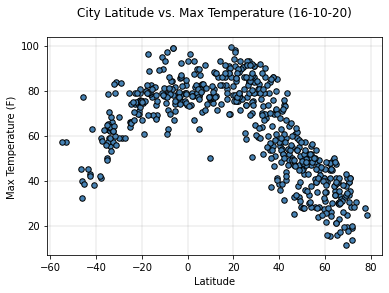

In [68]:
# Generating a scatter plot of Latitude vs. Temperature

y_lbl = "Max Temperature (F)"
title = "Max Temperature"
file_name = "Temp_vs_Lat.png"

# calling plot_vs_lat function
plot_vs_lat("Max Temp", y_lbl, title, file_name)


## Latitude vs. Humidity Plot

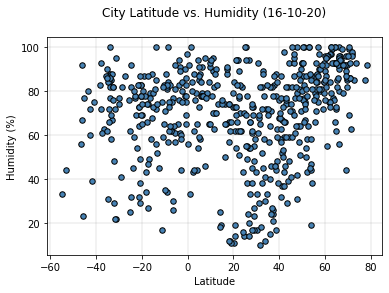

In [69]:
# Generating a scatter plot of Latitude vs. Humidity

y_lbl = "Humidity (%)"
title = "Humidity"
file_name = "Humidity_vs_Lat.png"

# calling plot_vs_lat function
plot_vs_lat("Humidity", y_lbl, title, file_name)


## Latitude vs. Cloudiness Plot

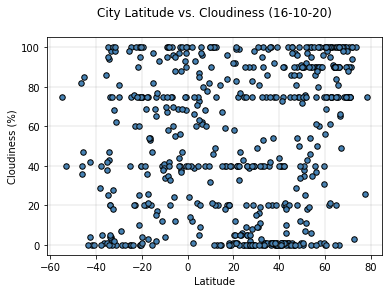

In [70]:
# Generating a scatter plot of Latitude vs. Cloudiness

y_lbl = "Cloudiness (%)"
title = "Cloudiness"
file_name = "Clouds_vs_Lat.png"

# calling plot_vs_lat function
plot_vs_lat("Cloudiness", y_lbl, title, file_name)


## Latitude vs. Wind Speed Plot

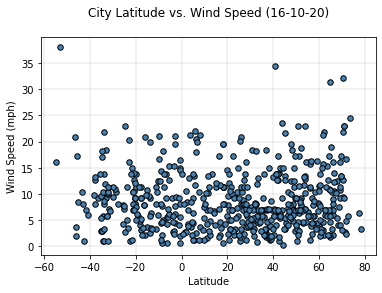

In [71]:
# Generating a scatter plot of Latitude vs. Wind Speed

y_lbl = "Wind Speed (mph)"
title = "Wind Speed"
file_name = "Wind_vs_Lat.png"

# calling plot_vs_lat function
plot_vs_lat("Wind Speed", y_lbl, title, file_name)


## Linear Regression

####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

In [42]:
clean_city_data = clean_city_data.dropna(how='any')
north_city_data = clean_city_data[clean_city_data['Lat'] > 0]
south_city_data = clean_city_data[clean_city_data['Lat'] < 0]


The r-value is: nan
r squared: 0.7511503208600918


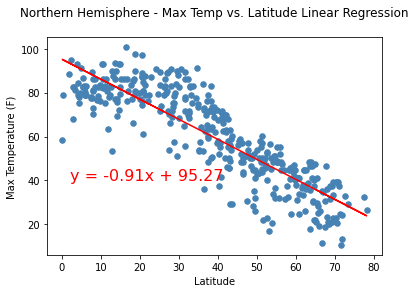

In [63]:
# Setting Latitude and Max Temp of Northern Hemisphere into x and y value lists
x_values = north_city_data['Lat']
y_values = north_city_data['Max Temp']

# Calculating and Printing Pearson correlation coefficient 
correlation = st.pearsonr(x_values, y_values)
print(f"\nThe r-value is: {correlation[0]}")


# Setting the figure size
fig = plt.figure()

# Creating subplot (1x1 grid, 1st subplot)
ax = fig.add_subplot(1,1,1)


# Finding slope and y intercept of line, r value, p value and standard error using scipy.stats.linregress function
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_values, y_values)

# Print r square value
print(f"r squared: {rvalue**2}")

# Line equation y=mx+b
regress_values = slope * x_values + intercept

# Line equation string y=mx+b to diplay
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Creating a scatter plot of Weight and Average Tumor volume
plt.scatter(x_values, y_values, color='steelblue', s=30)

# Creating a line plot (red solid)
plt.plot(x_values, regress_values, "r-")

# Adding line_eq string at specified position
plt.annotate(line_eq,(2,40),fontsize=16,color="red")

# Adding title and labels to the plot 
plt.title("Northern Hemisphere - Max Temp vs. Latitude Linear Regression\n")
plt.xlabel('Latitude')
plt.ylabel('Max Temperature (F)')

# Save figure as png file
plt.savefig("../Images/Temp_vs_Lat_North.png")

# Print our chart to the screen
plt.show()

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression


The r-value is: 0.7240009366633483
r squared: 0.5241773562894059


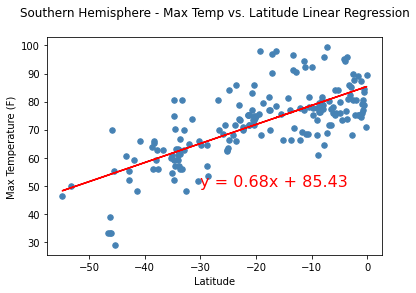

In [64]:
# Setting Latitude and Max Temp of Southern Hemisphere into x and y value lists
x_values = south_city_data['Lat']
y_values = south_city_data['Max Temp']

# Calculating and Printing Pearson correlation coefficient 
correlation = st.pearsonr(x_values, y_values)
print(f"\nThe r-value is: {correlation[0]}")


# Setting the figure size
fig = plt.figure()

# Creating subplot (1x1 grid, 1st subplot)
ax = fig.add_subplot(1,1,1)


# Finding slope and y intercept of line, r value, p value and standard error using scipy.stats.linregress function
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_values, y_values)

# Print r square value
print(f"r squared: {rvalue**2}")

# Line equation y=mx+b
regress_values = slope * x_values + intercept

# Line equation string y=mx+b to diplay
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Creating a scatter plot of Weight and Average Tumor volume
plt.scatter(x_values, y_values, color='steelblue', s=30)

# Creating a line plot (red solid)
plt.plot(x_values, regress_values, "r-")

# Adding line_eq string at specified position
plt.annotate(line_eq,(-30,50),fontsize=16,color="red")

# Adding title and labels to the plot 
plt.title("Southern Hemisphere - Max Temp vs. Latitude Linear Regression\n")
plt.xlabel('Latitude')
plt.ylabel('Max Temperature (F)')

# Save figure as png file
plt.savefig("../Images/Temp_vs_Lat_South.png")

# Print our chart to the screen
plt.show()

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression


The r-value is: 0.2380029283672691
r squared: 0.05664539391139547


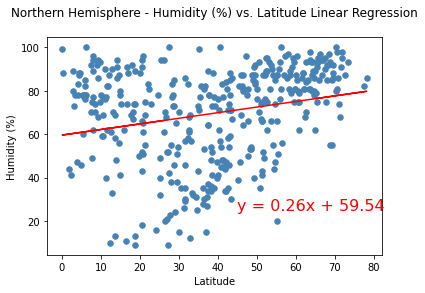

In [65]:
# Setting Latitude and Humidity of Northern Hemisphere into x and y value lists
x_values = north_city_data['Lat']
y_values = north_city_data['Humidity']

# Calculating and Printing Pearson correlation coefficient 
correlation = st.pearsonr(x_values, y_values)
print(f"\nThe r-value is: {correlation[0]}")


# Setting the figure size
fig = plt.figure()

# Creating subplot (1x1 grid, 1st subplot)
ax = fig.add_subplot(1,1,1)


# Finding slope and y intercept of line, r value, p value and standard error using scipy.stats.linregress function
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_values, y_values)

# Print r square value
print(f"r squared: {rvalue**2}")

# Line equation y=mx+b
regress_values = slope * x_values + intercept

# Line equation string y=mx+b to diplay
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Creating a scatter plot of Weight and Average Tumor volume
plt.scatter(x_values, y_values, color='steelblue', s=30)

# Creating a line plot (red solid)
plt.plot(x_values, regress_values, "r-")

# Adding line_eq string at specified position
plt.annotate(line_eq,(45,25),fontsize=16,color="red")

# Adding title and labels to the plot 
plt.title("Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression\n")
plt.xlabel('Latitude')
plt.ylabel('Humidity (%)')

# Save figure as png file
plt.savefig("../Images/Humidity_vs_Lat_North.png")

# Print our chart to the screen
plt.show()

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression


The r-value is: 0.07817732702235784
r squared: 0.006111694460360684


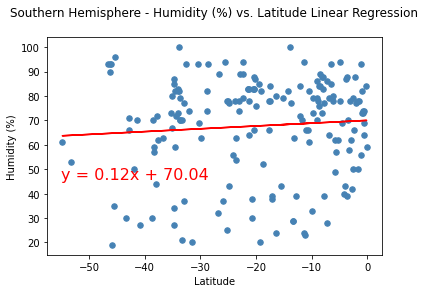

In [66]:
# Setting Latitude and Humidity of Southern Hemisphere into x and y value lists
x_values = south_city_data['Lat']
y_values = south_city_data['Humidity']

# Calculating and Printing Pearson correlation coefficient 
correlation = st.pearsonr(x_values, y_values)
print(f"\nThe r-value is: {correlation[0]}")


# Setting the figure size
fig = plt.figure()

# Creating subplot (1x1 grid, 1st subplot)
ax = fig.add_subplot(1,1,1)


# Finding slope and y intercept of line, r value, p value and standard error using scipy.stats.linregress function
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_values, y_values)

# Print r square value
print(f"r squared: {rvalue**2}")

# Line equation y=mx+b
regress_values = slope * x_values + intercept

# Line equation string y=mx+b to diplay
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Creating a scatter plot of Weight and Average Tumor volume
plt.scatter(x_values, y_values, color='steelblue', s=30)

# Creating a line plot (red solid)
plt.plot(x_values, regress_values, "r-")

# Adding line_eq string at specified position
plt.annotate(line_eq,(-55,46),fontsize=16,color="red")

# Adding title and labels to the plot 
plt.title("Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression\n")
plt.xlabel('Latitude')
plt.ylabel('Humidity (%)')

# Save figure as png file
plt.savefig("../Images/Humidity_vs_Lat_South.png")

# Print our chart to the screen
plt.show()

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression


The r-value is: 0.16643566068687213
r squared: 0.027700829148275652


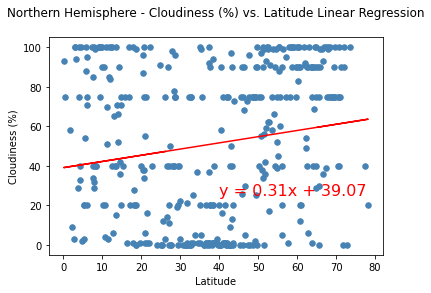

In [67]:
# Setting Latitude and Cloudiness of Northern Hemisphere into x and y value lists
x_values = north_city_data['Lat']
y_values = north_city_data['Cloudiness']

# Calculating and Printing Pearson correlation coefficient 
correlation = st.pearsonr(x_values, y_values)
print(f"\nThe r-value is: {correlation[0]}")


# Setting the figure size
fig = plt.figure()

# Creating subplot (1x1 grid, 1st subplot)
ax = fig.add_subplot(1,1,1)


# Finding slope and y intercept of line, r value, p value and standard error using scipy.stats.linregress function
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_values, y_values)

# Print r square value
print(f"r squared: {rvalue**2}")

# Line equation y=mx+b
regress_values = slope * x_values + intercept

# Line equation string y=mx+b to diplay
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Creating a scatter plot of Weight and Average Tumor volume
plt.scatter(x_values, y_values, color='steelblue', s=30)

# Creating a line plot (red solid)
plt.plot(x_values, regress_values, "r-")

# Adding line_eq string at specified position
plt.annotate(line_eq,(40,25),fontsize=16,color="red")

# Adding title and labels to the plot 
plt.title("Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression\n")
plt.xlabel('Latitude')
plt.ylabel('Cloudiness (%)')

# Save figure as png file
plt.savefig("../Images/Clouds_vs_Lat_North.png")

# Print our chart to the screen
plt.show()

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression


The r-value is: 0.3313110549329247
r squared: 0.10976701512076743


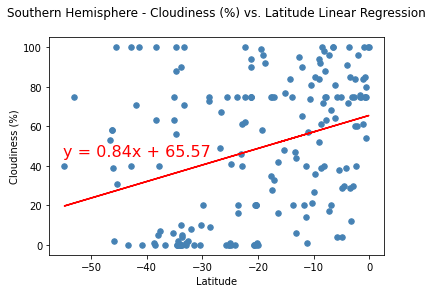

In [68]:
# Setting Latitude and Cloudiness of Southern Hemisphere into x and y value lists
x_values = south_city_data['Lat']
y_values = south_city_data['Cloudiness']

# Calculating and Printing Pearson correlation coefficient 
correlation = st.pearsonr(x_values, y_values)
print(f"\nThe r-value is: {correlation[0]}")


# Setting the figure size
fig = plt.figure()

# Creating subplot (1x1 grid, 1st subplot)
ax = fig.add_subplot(1,1,1)


# Finding slope and y intercept of line, r value, p value and standard error using scipy.stats.linregress function
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_values, y_values)

# Print r square value
print(f"r squared: {rvalue**2}")

# Line equation y=mx+b
regress_values = slope * x_values + intercept

# Line equation string y=mx+b to diplay
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Creating a scatter plot of Weight and Average Tumor volume
plt.scatter(x_values, y_values, color='steelblue', s=30)

# Creating a line plot (red solid)
plt.plot(x_values, regress_values, "r-")

# Adding line_eq string at specified position
plt.annotate(line_eq,(-55,45),fontsize=16,color="red")

# Adding title and labels to the plot 
plt.title("Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression\n")
plt.xlabel('Latitude')
plt.ylabel('Cloudiness (%)')

# Save figure as png file
plt.savefig("../Images/Clouds_vs_Lat_South.png")

# Print our chart to the screen
plt.show()

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression


The r-value is: 0.11153514432172212
r squared: 0.012440088418867389


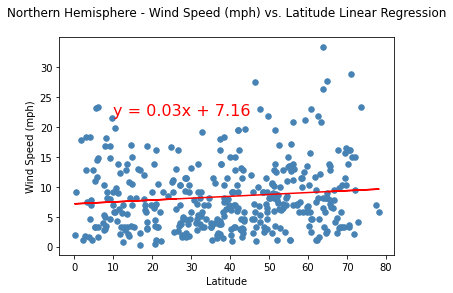

In [69]:
# Setting Latitude and Wind Speed of Northern Hemisphere into x and y value lists
x_values = north_city_data['Lat']
y_values = north_city_data['Wind Speed']

# Calculating and Printing Pearson correlation coefficient 
correlation = st.pearsonr(x_values, y_values)
print(f"\nThe r-value is: {correlation[0]}")


# Setting the figure size
fig = plt.figure()

# Creating subplot (1x1 grid, 1st subplot)
ax = fig.add_subplot(1,1,1)


# Finding slope and y intercept of line, r value, p value and standard error using scipy.stats.linregress function
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_values, y_values)

# Print r square value
print(f"r squared: {rvalue**2}")

# Line equation y=mx+b
regress_values = slope * x_values + intercept

# Line equation string y=mx+b to diplay
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Creating a scatter plot of Weight and Average Tumor volume
plt.scatter(x_values, y_values, color='steelblue', s=30)

# Creating a line plot (red solid)
plt.plot(x_values, regress_values, "r-")

# Adding line_eq string at specified position
plt.annotate(line_eq,(10,22),fontsize=16,color="red")

# Adding title and labels to the plot 
plt.title("Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression\n")
plt.xlabel('Latitude')
plt.ylabel('Wind Speed (mph)')

# Save figure as png file
plt.savefig("../Images/Wind_vs_Lat_North.png")

# Print our chart to the screen
plt.show()

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression


The r-value is: -0.14415304094950054
r squared: 0.020780099214988388


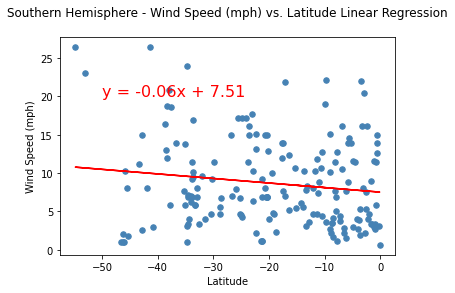

In [71]:
# Setting Latitude and Wind Speed of Southern Hemisphere into x and y value lists
x_values = south_city_data['Lat']
y_values = south_city_data['Wind Speed']

# Calculating and Printing Pearson correlation coefficient 
correlation = st.pearsonr(x_values, y_values)
print(f"\nThe r-value is: {correlation[0]}")


# Setting the figure size
fig = plt.figure()

# Creating subplot (1x1 grid, 1st subplot)
ax = fig.add_subplot(1,1,1)


# Finding slope and y intercept of line, r value, p value and standard error using scipy.stats.linregress function
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_values, y_values)

# Print r square value
print(f"r squared: {rvalue**2}")

# Line equation y=mx+b
regress_values = slope * x_values + intercept

# Line equation string y=mx+b to diplay
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Creating a scatter plot of Weight and Average Tumor volume
plt.scatter(x_values, y_values, color='steelblue', s=30)

# Creating a line plot (red solid)
plt.plot(x_values, regress_values, "r-")

# Adding line_eq string at specified position
plt.annotate(line_eq,(-50,20),fontsize=16,color="red")

# Adding title and labels to the plot 
plt.title("Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression\n")
plt.xlabel('Latitude')
plt.ylabel('Wind Speed (mph)')

# Save figure as png file
plt.savefig("../Images/Wind_vs_Lat_South.png")

# Print our chart to the screen
plt.show()